In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, 

####Read in sample metadata and OTU table

In [4]:
%%R 
physeq = import_biom("data/otu_table_JSON_wtax.biom", "data/otusn_JSON.tree")
print(physeq)
sample.data = import_qiime_sample_data("data/JSON_mapping_file.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
print(physeq)
physeq = prune_samples((physeq.md$Treatment %in% c("NTH", "PTH")) & (physeq.md$Month == "November"), physeq)

physeq.md = sample_data(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 82 samples ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9756 taxa and 82 samples ]
sample_data() Sample Data:       [ 82 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9756 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9756 tips and 9755 internal nodes ]


In [5]:
%%R
dds = phyloseq_to_deseq2(physeq, ~Till) # Making DeSeq Data set
dds = DESeq(dds) # Running 
dds
r = results(dds, cooksCutoff = FALSE, independentFiltering = TRUE, pAdjustMethod = "BH")

r

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
log2 fold change (MAP): Till P vs N 
Wald test p-value: Till P vs N 
DataFrame with 9756 rows and 6 columns
           baseMean log2FoldChange     lfcSE       stat    pvalue      padj
          <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
OTU.7316  0.0000000             NA        NA         NA        NA        NA
OTU.9404  0.0000000             NA        NA         NA        NA        NA
OTU.5128  0.3106776     -0.3235409  1.304214 -0.2480735 0.8040775        NA
OTU.10969 0.0000000             NA        NA         NA        NA        NA
OTU.10860 0.0000000             NA        NA         NA        NA        NA
...             ...            ...       ...        ...       ...       ...
OTU.5539  0.0000000             NA        NA         NA        NA        NA
OTU.11559 0.29

In [6]:
%%R
r$OTU = rownames(r)
d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "pvalue", "padj")])
TT = data.frame(tax_table(physeq))
TT$OTU = rownames(TT)
d = left_join(d, TT)
head(d)
df.l2fc = tbl_df(d)
head(df.l2fc)

Joining by: "OTU"
Source: local data frame [6 x 13]

        OTU log2FoldChange    lfcSE    pvalue padj    Rank1             Rank2
1  OTU.7316             NA       NA        NA   NA Bacteria __Armatimonadetes
2  OTU.9404             NA       NA        NA   NA Bacteria   __Acidobacteria
3  OTU.5128     -0.3235409 1.304214 0.8040775   NA Bacteria   __Acidobacteria
4 OTU.10969             NA       NA        NA   NA Bacteria   __Acidobacteria
5 OTU.10860             NA       NA        NA   NA Bacteria   __Acidobacteria
6   OTU.726     -1.4347071 1.324385 0.2786748   NA Bacteria   __Acidobacteria
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7 (fctr), Rank8 (fctr)


####mdply call with function arguments

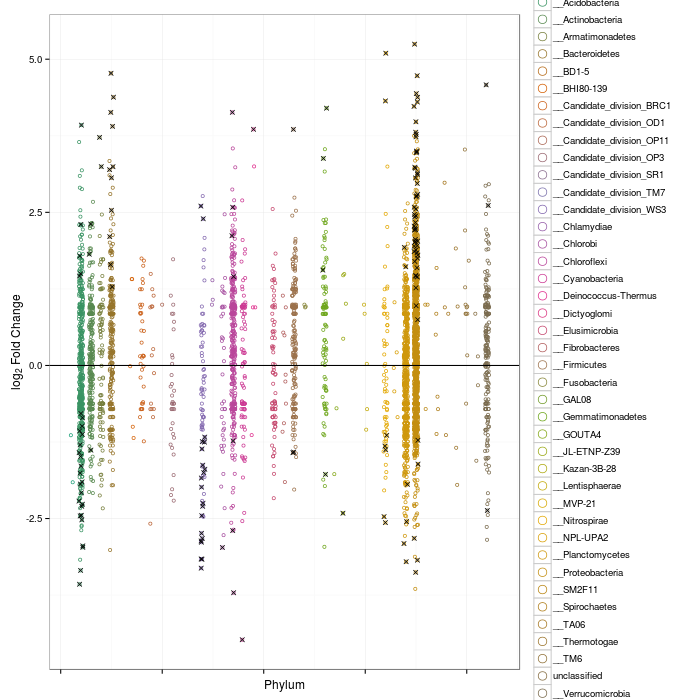

In [8]:
%%R -w 700 -h 700
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))


p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj <= FDR), color = "black", shape = 4, size = 2)

p = p + geom_hline(y = 0)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [16]:
%%R
head(df.l2fc)

Source: local data frame [6 x 13]

        OTU log2FoldChange    lfcSE    pvalue padj    Rank1             Rank2
1  OTU.7316             NA       NA        NA   NA Bacteria __Armatimonadetes
2  OTU.9404             NA       NA        NA   NA Bacteria   __Acidobacteria
3  OTU.5128     -0.3235409 1.304214 0.8040775   NA Bacteria   __Acidobacteria
4 OTU.10969             NA       NA        NA   NA Bacteria   __Acidobacteria
5 OTU.10860             NA       NA        NA   NA Bacteria   __Acidobacteria
6   OTU.726     -1.4347071 1.324385 0.2786748   NA Bacteria   __Acidobacteria
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7 (fctr), Rank8 (fctr)


In [46]:
%%R 
 new_df.l2fc = df.l2fc %>% 
filter(!is.na(log2FoldChange)) %>% 
filter(!is.na(padj)) %>%
select(log2FoldChange, padj, OTU, Rank2) 



In [50]:
%%R
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = "unknown"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange > 0] = "NTH responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 &  new_df.l2fc$log2FoldChange < 0] = "PTH responder"

In [51]:
%%R
new_df.l2fc

Source: local data frame [1,156 x 5]

   log2FoldChange        padj      OTU           Rank2   Resp_status
1      -2.9454558 0.091759985 OTU.1606 __Acidobacteria PTH responder
2       1.0859240 0.450353720  OTU.580 __Acidobacteria       unknown
3       1.5127337 0.448869749 OTU.5023 __Acidobacteria       unknown
4       0.3112181 0.880212526  OTU.585 __Acidobacteria       unknown
5      -0.4593197 0.714951339  OTU.665 __Acidobacteria       unknown
6      -0.3160365 0.706086342   OTU.33 __Acidobacteria       unknown
7      -1.6419801 0.008649815  OTU.211 __Acidobacteria PTH responder
8       0.2077283 0.854255842 OTU.1756 __Acidobacteria       unknown
9      -0.5133473 0.652403341 OTU.4243 __Acidobacteria       unknown
10      0.6504530 0.595687365  OTU.634 __Acidobacteria       unknown
..            ...         ...      ...             ...           ...


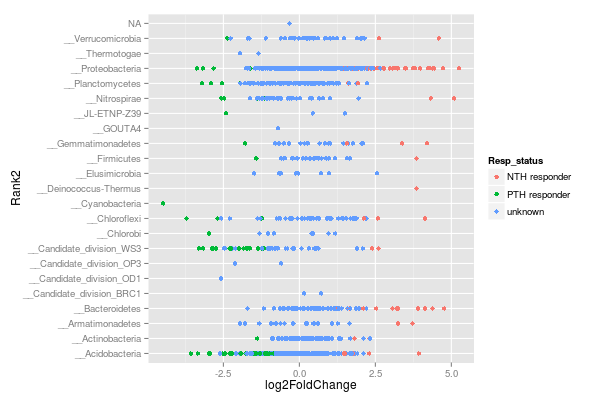

In [52]:
%%R -w 600 -h 400
p = ggplot(new_df.l2fc, aes(log2FoldChange, Rank2))
p = p + geom_point(aes(color = Resp_status))
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
#p = p + scale_colour_discrete((name="Responder Status"),
 #                        labels =c("Nonresponder/Unknown", "DNA and RNA Responder"))
p

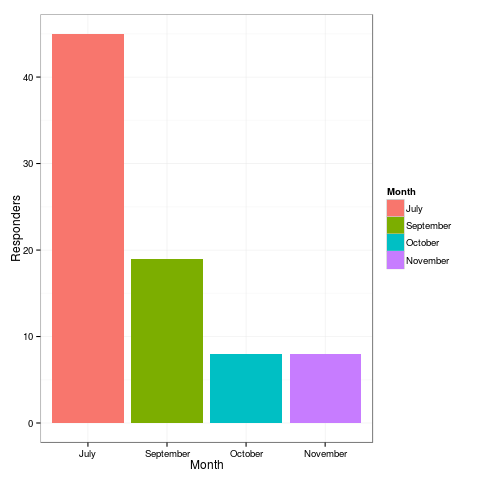

In [74]:
%%R
d = df.l2fc %>%
          group_by(Month) %>%
          summarize(responders = sum(padj <= 0.10))

d$Month <- factor(d$Month, levels = c("July", "September", "October", "November"))

px = ggplot(d, aes(x = (Month), y = responders, fill = Month))

px = px + geom_bar(stat = "identity", position = "dodge")

px = px + theme_bw()

px = px + xlab("Month") + ylab("Responders")


px

In [77]:
%%R
ggsave(filename = "data/figs/l2fc_histogram", plot = px, width = 12, height = 7)

In [ ]:
%%R -w 300 -h 200
FDR = 0.10
DNAresp = df.l2fc %.% 
                filter(RNA_DNA == "DNA", padj <= FDR) %>% 
                select(log2FoldChange, Day, padj, OTU, Rank2)%>%
                ungroup()
colnames(DNAresp)[2] = "DNA_l2fc"
colnames(DNAresp)[4] = "DNA_padj"  

RNAnonresp = df.l2fc %.% 
                filter(RNA_DNA == "RNA", padj >= FDR) %>% 
                select(log2FoldChange, Day, padj, OTU)%>%
                ungroup()
colnames(RNAnonresp)[2] = "RNA_l2fc"  
colnames(RNAnonresp)[4] = "RNA_padj"  

d.DNAresp = left_join(DNAresp, RNAnonresp, by = c("OTU", "Day")) %>% filter(!is.na(RNA_l2fc))

In [ ]:
%%R
print(length(unique(d.DNAresp$OTU)))

In [ ]:
%%R -w 300 -h 200
FDR = 0.10
DNAnonresp = df.l2fc %.% 
                filter(RNA_DNA == "DNA", padj >= FDR) %>% 
                select(log2FoldChange, Day, padj, OTU, Rank2)%>%
                ungroup()
colnames(DNAnonresp)[2] = "DNA_l2fc"
colnames(DNAnonresp)[4] = "DNA_padj"  

RNAnonresp = df.l2fc %.% 
                filter(RNA_DNA == "RNA", padj >= FDR) %>% 
                select(log2FoldChange, Day, padj, OTU)%>%
                ungroup()
colnames(RNAnonresp)[2] = "RNA_l2fc"  
colnames(RNAnonresp)[4] = "RNA_padj"  

nonresp = left_join(DNAnonresp, RNAnonresp, by = c("OTU", "Day")) %>% filter(!is.na(RNA_l2fc), !is.na(DNA_l2fc))

In [ ]:
%%R
print(length(unique(nonresp$OTU)))


In [ ]:
%%R -w 300 -h 200
FDR = 0.10
DNAresp = df.l2fc %.% 
                filter(RNA_DNA == "DNA", padj <= FDR) %>% 
                select(log2FoldChange, Day, padj, OTU, Rank2)%>%
                ungroup()
colnames(DNAresp)[2] = "DNA_l2fc"
colnames(DNAresp)[4] = "DNA_padj"  

RNAresp = df.l2fc %.% 
                filter(RNA_DNA == "RNA", padj <= FDR) %>% 
                select(log2FoldChange, Day, padj, OTU)%>%
                ungroup()
colnames(RNAresp)[2] = "RNA_l2fc"  
colnames(RNAresp)[4] = "RNA_padj"  

resp = left_join(DNAresp, RNAresp, by = c("OTU", "Day")) %>% filter(!is.na(RNA_l2fc), !is.na(DNA_l2fc))

In [ ]:
%%R
print(length(unique(resp$OTU)))

In [ ]:
%%R
mult_OTUs = group_by(resp, OTU)
mult_OTUs = summarise(mult_OTUs,
  count = n())
mult_OTUs = filter(mult_OTUs, count >1)

mult_OTUs = mult_OTUs$OTU

mult = resp %>%
                    filter(OTU %in% mult_OTUs) %>%
                    arrange(OTU)

mult

## Blasting against Living Tree Project db

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline as blast

In [ ]:
from cogent import LoadSeqs, DNA


In [ ]:
OTU_ids = ["OTU.162", "OTU.239", "OTU.2456", "OTU.256", "OTU.3194", "OTU.80"]
seqs = LoadSeqs("/home/chantal/RNASIP/data/totalRNA.otusn.fasta", moltype=DNA, aligned=False)
seqs = seqs.takeSeqs(OTU_ids).toFasta()
print seqs

In [ ]:
my_file = open("seqs.fasta", "w")
my_file.write(seqs)
my_file.close()

In [ ]:
cline = blast(query = "seqs.fasta",
              db = "/var/seq_data/silva/silva_blastdb/silva_RefNR_115",
              outfmt = 6,
              out = "otusn_silvaRefNR115.m6",
              num_threads = 5)
print cline
cline()

In [ ]:
!head -n1 otusn_silvaRefNR115.m6
!wc -l otusn_silvaRefNR115.m6
! grep -c "OTU.80" otusn_silvaRefNR115.m6

In [ ]:
from IPython.display import Image
import pandas.rpy.common as com

In [ ]:
%%R
library(data.table)
library(dplyr)

In [ ]:
%%R
blastout_dt = fread("otusn_silvaRefNR115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %>% 
                          group_by(OTU) %>% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %>% 
                          filter(pid > 97.0) %>%
                          filter(e.value < 5.0e-180) %>%
                          filter(acc %in% c('AM286414', 'AB428568', 'EU877263', 'EF575565', 'EF494193', 'X82449'))

In [ ]:
%%R
print(head(top_hits_df_LTP))
str(top_hits_df_LTP$OTU)

In [ ]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";")
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [ ]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)

In [ ]:
%%R
joined_df = filter(joined_df, name != "NA")

In [ ]:
%%R
dim(joined_df)

In [ ]:
df = com.load_data("joined_df")

In [ ]:
def get_latex(df):
    latex = ""
    prefix = r"\multirow{%s}{*}{%s}"%(len(df.index), df.OTU.iloc[0])
    for i, r in df[["name","pid","acc"]].iterrows():
        latex += " & " + " & ".join([str(i) for i in r.values]) + r" \\ "
    return prefix + latex + r"\midrule" + "\n"

In [ ]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{13}$C RNA responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{l>{\itshape}lrl}
    \toprule \\
    \textbf{OTU ID} & \textbf{Species Name} & \textbf{BLAST percent identity} & \textbf{accession} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [ ]:
!latex -output-directory="../data/tmp" ../data/tmp/table.tex >/dev/null 2>&1 && \
dvipng -o ../data/table.png ../data/tmp/table.dvi >/dev/null 2>&1
Image("../data/table.png")